In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import figure

Importing Datasets

In [99]:
gold = pd.read_csv('/Users/alyssalung/Downloads/LBMA-GOLD.csv')
gold.head()
gold.tail()

,Date,USD (PM)
1260,9/6/21,1821.60
1261,9/7/21,1802.15
1262,9/8/21,1786.00
1263,9/9/21,1788.25
1264,9/10/21,1794.60


In [100]:
bitcoin = pd.read_csv('/Users/alyssalung/Downloads/BCHAIN-MKPRU.csv')
bitcoin.head()

,Date,Value
0,9/11/16,621.65
1,9/12/16,609.67
2,9/13/16,610.92
3,9/14/16,608.82
4,9/15/16,610.38


Data Preprocessing: Merge gold and bitcoin dataframes, forward fill missing values of Gold

make note of this in assumptions for buying/selling gold^

In [101]:
df = pd.merge(bitcoin, gold, on="Date", how="left")
df.columns = ['Date', 'Bitcoin', 'Gold']
df.Gold = df.Gold.ffill()
df.Gold.loc[0] = 1324.60
df.head()

/Users/alyssalung/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Date,Bitcoin,Gold
0,9/11/16,621.65,1324.60
1,9/12/16,609.67,1324.60
2,9/13/16,610.92,1323.65
3,9/14/16,608.82,1321.75
4,9/15/16,610.38,1310.80


Plot asset prices and moving averages

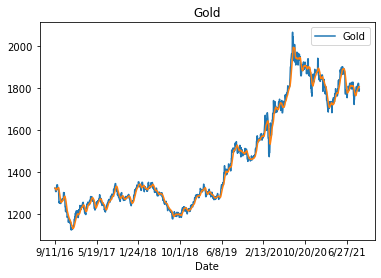

In [102]:
#plot gold prices
df.plot(x = "Date", y = "Gold")
#plot gold moving average
start_date = 0
end_date = 1826
df['Gold'][start_date:end_date].rolling(14, min_periods=1).mean().plot()
plt.title('Gold')
plt.show()

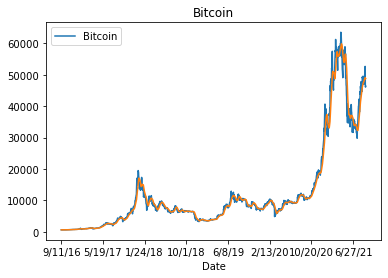

In [103]:
#plot gold prices
df.plot(x = "Date", y = "Bitcoin")
#plot gold moving average
days_passed = 1826
df['Bitcoin'][start_date:end_date].rolling(14, min_periods=1).mean().plot()
plt.title('Bitcoin')
#plt.axvline(x=days_passed, c = "red")
plt.show()

Save moving average points as a dataset

In [104]:
#when window is bigger, the moving average curve is smoother (less similar to the actual prices)
bitcoin_moving_avg = df['Bitcoin'][start_date:end_date].rolling(14, min_periods=1).mean()
bitcoin_moving_avg

0         621.650000
1         615.660000
2         614.080000
3         612.765000
4         612.288000
            ...     
1821    48867.031429
1822    49092.310000
1823    49025.495000
1824    48818.801429
1825    48776.365000
Name: Bitcoin, Length: 1826, dtype: float64

In [105]:
gold_moving_avg = df['Gold'][start_date:end_date].rolling(14, min_periods=1).mean()
gold_moving_avg

0       1324.600000
1       1324.600000
2       1324.283333
3       1323.650000
4       1321.080000
           ...     
1821    1807.832143
1822    1807.382143
1823    1807.189286
1824    1807.307143
1825    1807.028571
Name: Gold, Length: 1826, dtype: float64

In [106]:
##dataset for the difference between actual price and the moving average
gold_diff = df['Gold'] - gold_moving_avg
bitcoin_diff = df['Bitcoin'] - bitcoin_moving_avg


Iteration ideas: 
1. change the specific number for the criteria and see output on final profit (sensitivity analysis). Ex: if difference is below x we buy and if diff is above y we sell. Adjust values of x and y.
2. First start with 500 in bitcoin and 500 in gold, and then next iteration we add the criteria, and then next iteration we see they interact w each other.


In [107]:
print("max diff:", gold_diff.max())
print("min diff:",gold_diff.min())
print("mean diff:",gold_diff.mean())
print("median diff:",gold_diff.median())

max diff: 107.23214285714312
min diff: -133.48928571428587
mean diff: 1.7237512751183344
median diff: 2.6428571428571104


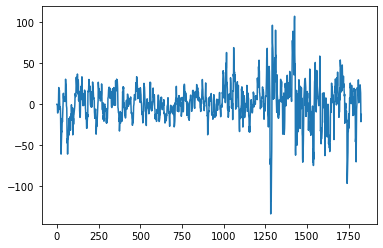

In [108]:
plt.plot(gold_diff);

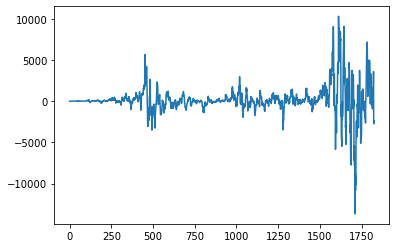

In [109]:
plt.plot(bitcoin_diff);

In [127]:
sum(gold_diff > 75)

9

### Model 1

Ending Value 2.9431857085870816
Number of Transactions 1113


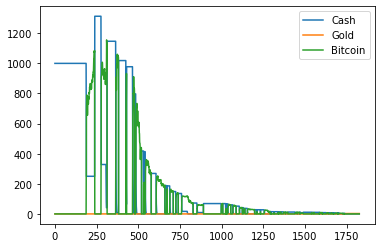

In [145]:
##cash,gold,bitcoin
statelist = [[1000,0,0]]

goldchange = 1
bitchange = 1
gold_transfee = .01
bc_transfee = 0.02

num_trades = 0

for i in range(1826):
    cashyest = statelist[-1][0]
    goldyest = statelist[-1][1]
    bityest = statelist[-1][2]
    buy_gold = False
    buy_bc = False
    if i > 0:
        goldchange = 1 + ((df['Gold'][i] - df['Gold'][i-1]) / df['Gold'][i-1])
        bitchange = 1 + ((df['Bitcoin'][i]-df['Bitcoin'][i-1]) / df['Bitcoin'][i-1])
    
    #sell gold 
    if(gold_diff[i] >= 75):
        cashyest += goldyest * (1-gold_transfee)
        goldyest = 0
        num_trades+=1

    #sell bitcoin   
    if(bitcoin_diff[i] >= 200):
        cashyest += bityest* (1-bc_transfee)
        bityest = 0  
        num_trades+=1

    #buy gold
    if(gold_diff[i] <= -75):
        buy_gold = True
        num_trades+=1

        
    #buy bitcoin   
    if(bitcoin_diff[i] <= -200):
        buy_bc = True
        num_trades+=1
 

    if buy_gold and buy_bc:
        goldyest += cashyest/2 * (1-gold_transfee)
        bityest += cashyest/2 * (1 - bc_transfee)
        cashyest = 0
    elif buy_gold: 
        goldyest += cashyest/2 * (1-gold_transfee)
        cashyest = cashyest/2
    elif buy_bc: 
        bityest += cashyest/2 * (1 - bc_transfee)
        cashyest = cashyest/2
        
    if i > 0:
        statelist.append([cashyest, goldyest * goldchange, bityest * bitchange ])
        
        
        
plt.plot(statelist)
plt.legend(["Cash", "Gold", "Bitcoin"]);
print('Ending Value', statelist[-1][0] + statelist[-1][1] + statelist[-1][2])
print('Number of Transactions', num_trades)

### Model 2: Use 20% difference between moving average and price instead of set dollar amount change

Ending Value: 27344.125690687182
Number of Trades: 63


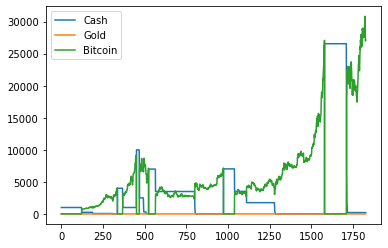

In [155]:
##cash,gold,bitcoin
statelist = [[1000,0,0]]

goldchange = 1
bitchange = 1

gold_transfee = .01
bc_transfee = 0.02

gold_diff_change = 0
bit_diff_change = 0
num_trades = 0

for i in range(1826):
    cashyest = statelist[-1][0]
    goldyest = statelist[-1][1]
    bityest = statelist[-1][2]
    buy_bc = False
    buy_gold = False
    if i > 0:
        goldchange = 1 + ((df['Gold'][i] - df['Gold'][i-1]) / df['Gold'][i-1])
        bitchange = 1 + ((df['Bitcoin'][i]-df['Bitcoin'][i-1]) / df['Bitcoin'][i-1])
        
        gold_diff_change = gold_diff[i]/df['Gold'][i]
        bit_diff_change = bitcoin_diff[i]/df['Bitcoin'][i]

    #sell gold 
    if(gold_diff_change >= .2):
        cashyest += goldyest * (1-gold_transfee)
        goldyest = 0
        num_trades+=1


    #sell bitcoin   
    if(bit_diff_change >= .2):
        cashyest += bityest * (1-bc_transfee)
        bityest = 0
        num_trades+=1
       
    #buy gold
    if(gold_diff_change <= -.2):
        buy_gold = True
        num_trades+=1
      
    #buy bitcoin   
    if(bit_diff_change <= -.2):
        buy_bc = True
        num_trades+=1
        
    if buy_gold and buy_bc:
        goldyest += cashyest/2 * (1-gold_transfee)
        bityest += cashyest/2 * (1 - bc_transfee)
        cashyest = 0
    
    elif buy_gold: 
        goldyest += cashyest/2 * (1-gold_transfee)
        cashyest = cashyest/2
    elif buy_bc: 
        bityest += cashyest/2 * (1 - bc_transfee)
        cashyest = cashyest/2
    
    if i > 0:
        statelist.append([cashyest, goldyest * goldchange, bityest * bitchange ])
        
        
plt.plot(statelist)
plt.legend(["Cash", "Gold", "Bitcoin"]);
print('Ending Value:', statelist[-1][0] + statelist[-1][1] + statelist[-1][2])
print('Number of Trades:', num_trades)

In [114]:
statelist[-1]

[207.37423506223178, 0.0, 27136.75145562495]

### Model 3.1: Lowering buying/selling thresholds for gold, keep bitcoin at 20%
Sell Gold: 2%
Buy Gold: -2%

Ending Value: 13931.003239436062
Number of Trades: 311


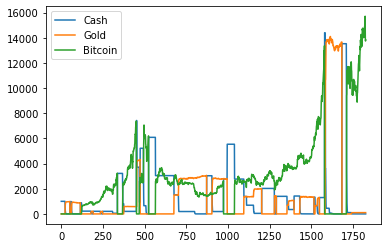

In [159]:
##cash,gold,bitcoin
statelist = [[1000,0,0]]
allowgoldbuy = True
allowbitbuy = True

goldchange = 1
bitchange = 1

gold_diff_change = 0
bit_diff_change = 0

gold_transfee = 0.01
bc_transfee = 0.02
num_trades = 0

for i in range(1826):
    cashyest = statelist[-1][0]
    goldyest = statelist[-1][1]
    bityest = statelist[-1][2]
    buy_gold = False
    buy_bc = False
    if i > 0:
        goldchange = 1 + ((df['Gold'][i] - df['Gold'][i-1]) / df['Gold'][i-1])
        bitchange = 1 + ((df['Bitcoin'][i]-df['Bitcoin'][i-1]) / df['Bitcoin'][i-1])
        
        gold_diff_change = gold_diff[i]/df['Gold'][i]
        bit_diff_change = bitcoin_diff[i]/df['Bitcoin'][i]

    #sell gold 
    if(gold_diff_change >= .02):
        cashyest += goldyest * (1-gold_transfee)
        goldyest = 0
        num_trades += 1

    #sell bitcoin   
    if(bit_diff_change >= .2):
        cashyest += bityest * (1-bc_transfee)
        bityest = 0
        num_trades += 1
        
    #buy gold
    if(gold_diff_change <= -.02):
        buy_gold = True
        num_trades += 1
      
    #buy bitcoin   
    if(bit_diff_change <= -.2):
        buy_bc = True
        num_trades += 1
        
    if buy_gold and buy_bc:
        goldyest += cashyest/2 * (1-gold_transfee)
        bityest += cashyest/2 * (1 - bc_transfee)
        cashyest = 0
    
    elif buy_gold: 
        goldyest += cashyest/2 * (1-gold_transfee)
        cashyest = cashyest/2
    elif buy_bc: 
        bityest += cashyest/2 * (1 - bc_transfee)
        cashyest = cashyest/2    
    if i > 0:
        statelist.append([cashyest, goldyest * goldchange, bityest * bitchange ])
        
        
plt.plot(statelist)
plt.legend(["Cash", "Gold", "Bitcoin"]);
print('Ending Value:', statelist[-1][0] + statelist[-1][1] + statelist[-1][2])
print('Number of Trades:', num_trades)

### Model 3.2: Buy and Sell Gold at 3% Bitcoin at 20%

Ending Value: 17770.202731656835
Number of trades: 152


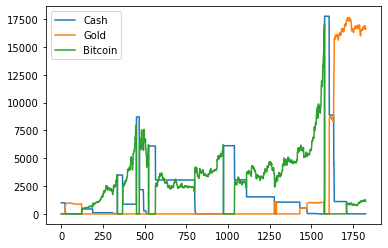

In [160]:
statelist = [[1000,0,0]]

goldchange = 1
bitchange = 1

gold_diff_change = 0
bit_diff_change = 0

gold_transfee = 0.01
bc_transfee = 0.02

num_trades = 0

for i in range(1826):
    cashyest = statelist[-1][0]
    goldyest = statelist[-1][1]
    bityest = statelist[-1][2]
    buy_gold = False
    buy_bc = False
    if i > 0:
        goldchange = 1 + ((df['Gold'][i] - df['Gold'][i-1]) / df['Gold'][i-1])
        bitchange = 1 + ((df['Bitcoin'][i]-df['Bitcoin'][i-1]) / df['Bitcoin'][i-1])
        
        gold_diff_change = gold_diff[i]/df['Gold'][i]
        bit_diff_change = bitcoin_diff[i]/df['Bitcoin'][i]

    #sell gold 
    if(gold_diff_change >= .03):
        cashyest += goldyest * (1-gold_transfee)
        goldyest = 0
        num_trades += 1

    #sell bitcoin   
    if(bit_diff_change >= .2):
        cashyest += bityest * (1-bc_transfee)
        bityest = 0
        num_trades += 1
   
    #buy gold
    if(gold_diff_change <= -.03):
        buy_gold = True
        num_trades += 1
      
    #buy bitcoin   
    if(bit_diff_change <= -.2):
        buy_bc = True
        num_trades += 1
        
    if buy_gold and buy_bc:
        goldyest += cashyest/2 * (1-gold_transfee)
        bityest += cashyest/2 * (1 - bc_transfee)
        cashyest = 0
    
    elif buy_gold: 
        goldyest += cashyest/2 * (1-gold_transfee)
        cashyest = cashyest/2
    elif buy_bc: 
        bityest += cashyest/2 * (1 - bc_transfee)
        cashyest = cashyest/2    
    
    if i > 0:
        statelist.append([cashyest, goldyest * goldchange, bityest * bitchange ])
        
        
plt.plot(statelist)
plt.legend(["Cash", "Gold", "Bitcoin"]);
print('Ending Value:', statelist[-1][0] + statelist[-1][1] + statelist[-1][2])
print('Number of trades:', num_trades)

### Model 3.3: Buying/selling gold at 4%, bitcoin at 20%

Ending Value: 4341.690381257603
Number of trades: 100


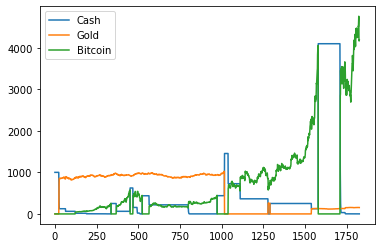

In [161]:
statelist = [[1000,0,0]]

goldchange = 1
bitchange = 1

gold_diff_change = 0
bit_diff_change = 0

gold_transfee = 0.01
bc_transfee = 0.02

num_trades = 0

for i in range(1826):
    cashyest = statelist[-1][0]
    goldyest = statelist[-1][1]
    bityest = statelist[-1][2]
    buy_gold = False
    buy_bc = False
    if i > 0:
        goldchange = 1 + ((df['Gold'][i] - df['Gold'][i-1]) / df['Gold'][i-1])
        bitchange = 1 + ((df['Bitcoin'][i]-df['Bitcoin'][i-1]) / df['Bitcoin'][i-1])
        
        gold_diff_change = gold_diff[i]/df['Gold'][i]
        bit_diff_change = bitcoin_diff[i]/df['Bitcoin'][i]

    #sell gold 
    if(gold_diff_change >= .04):
        cashyest += goldyest * (1-gold_transfee)
        goldyest = 0
        num_trades += 1

    #sell bitcoin   
    if(bit_diff_change >= .2):
        cashyest += bityest * (1-bc_transfee)
        bityest = 0
        num_trades += 1
   
    #buy gold
    if(gold_diff_change <= -.04):
        buy_gold = True
        num_trades += 1
      
    #buy bitcoin   
    if(bit_diff_change <= -.2):
        buy_bc = True
        num_trades += 1
        
    if buy_gold and buy_bc:
        goldyest += cashyest/2 * (1-gold_transfee)
        bityest += cashyest/2 * (1 - bc_transfee)
        cashyest = 0
    
    elif buy_gold: 
        goldyest += cashyest/2 * (1-gold_transfee)
        cashyest = cashyest/2
    elif buy_bc: 
        bityest += cashyest/2 * (1 - bc_transfee)
        cashyest = cashyest/2    
    
    if i > 0:
        statelist.append([cashyest, goldyest * goldchange, bityest * bitchange ])
        
        
plt.plot(statelist)
plt.legend(["Cash", "Gold", "Bitcoin"]);
print('Ending Value:', statelist[-1][0] + statelist[-1][1] + statelist[-1][2])
print('Number of trades:', num_trades)

### Model 4.1: Gold stable, sell/buy bitcoin at 15
%

Ending Value: 586.571039484014
Number of trades: 242


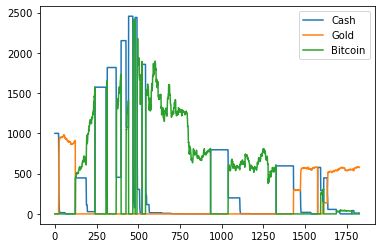

In [165]:
statelist = [[1000,0,0]]

goldchange = 1
bitchange = 1

gold_diff_change = 0
bit_diff_change = 0

gold_transfee = 0.01
bc_transfee = 0.02

num_trades = 0

for i in range(1826):
    cashyest = statelist[-1][0]
    goldyest = statelist[-1][1]
    bityest = statelist[-1][2]
    buy_gold = False
    buy_bc = False
    if i > 0:
        goldchange = 1 + ((df['Gold'][i] - df['Gold'][i-1]) / df['Gold'][i-1])
        bitchange = 1 + ((df['Bitcoin'][i]-df['Bitcoin'][i-1]) / df['Bitcoin'][i-1])
        
        gold_diff_change = gold_diff[i]/df['Gold'][i]
        bit_diff_change = bitcoin_diff[i]/df['Bitcoin'][i]

    #sell gold 
    if(gold_diff_change >= .03):
        cashyest += goldyest * (1-gold_transfee)
        goldyest = 0
        num_trades += 1

    #sell bitcoin   
    if(bit_diff_change >= .15):
        cashyest += bityest * (1-bc_transfee)
        bityest = 0
        num_trades += 1
   
    #buy gold
    if(gold_diff_change <= -.03):
        buy_gold = True
        num_trades += 1
      
    #buy bitcoin   
    if(bit_diff_change <= -.15):
        buy_bc = True
        num_trades += 1
        
    if buy_gold and buy_bc:
        goldyest += cashyest/2 * (1-gold_transfee)
        bityest += cashyest/2 * (1 - bc_transfee)
        cashyest = 0
    
    elif buy_gold: 
        goldyest += cashyest/2 * (1-gold_transfee)
        cashyest = cashyest/2
    elif buy_bc: 
        bityest += cashyest/2 * (1 - bc_transfee)
        cashyest = cashyest/2    
    
    if i > 0:
        statelist.append([cashyest, goldyest * goldchange, bityest * bitchange ])
        
        
plt.plot(statelist)
plt.legend(["Cash", "Gold", "Bitcoin"]);
print('Ending Value:', statelist[-1][0] + statelist[-1][1] + statelist[-1][2])
print('Number of trades:', num_trades)

### Model 4.2: Bitcoin at 25%, gold at 3%

Ending Value: 28847.888936358424
Number of trades: 115


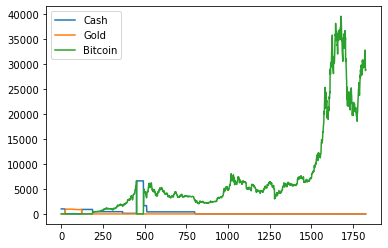

In [181]:
statelist = [[1000,0,0]]

goldchange = 1
bitchange = 1

gold_diff_change = 0
bit_diff_change = 0

gold_transfee = 0.01
bc_transfee = 0.02

num_trades = 0

for i in range(1826):
    cashyest = statelist[-1][0]
    goldyest = statelist[-1][1]
    bityest = statelist[-1][2]
    buy_gold = False
    buy_bc = False
    if i > 0:
        goldchange = 1 + ((df['Gold'][i] - df['Gold'][i-1]) / df['Gold'][i-1])
        bitchange = 1 + ((df['Bitcoin'][i]-df['Bitcoin'][i-1]) / df['Bitcoin'][i-1])
        
        gold_diff_change = gold_diff[i]/df['Gold'][i]
        bit_diff_change = bitcoin_diff[i]/df['Bitcoin'][i]

    #sell gold 
    if(gold_diff_change >= .03):
        cashyest += goldyest * (1-gold_transfee)
        goldyest = 0
        num_trades += 1

    #sell bitcoin   
    if(bit_diff_change >= .25):
        cashyest += bityest * (1-bc_transfee)
        bityest = 0
        num_trades += 1
   
    #buy gold
    if(gold_diff_change <= -.03):
        buy_gold = True
        num_trades += 1
      
    #buy bitcoin   
    if(bit_diff_change <= -.25):
        buy_bc = True
        num_trades += 1
        
    if buy_gold and buy_bc:
        goldyest += cashyest/2 * (1-gold_transfee)
        bityest += cashyest/2 * (1 - bc_transfee)
        cashyest = 0
    
    elif buy_gold: 
        goldyest += cashyest/2 * (1-gold_transfee)
        cashyest = cashyest/2
    elif buy_bc: 
        bityest += cashyest/2 * (1 - bc_transfee)
        cashyest = cashyest/2    
    
    if i > 0:
        statelist.append([cashyest, goldyest * goldchange, bityest * bitchange ])
        
        
plt.plot(statelist)
plt.legend(["Cash", "Gold", "Bitcoin"]);
print('Ending Value:', statelist[-1][0] + statelist[-1][1] + statelist[-1][2])
print('Number of trades:', num_trades)

### Model 5.1:
bitcoin - 20%
gold - 2%
sell/buy = 10% of value


Ending Value: 13005.391667702177
Number of Trades: 311


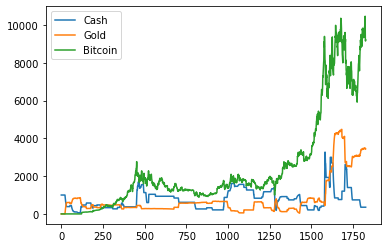

In [190]:
statelist = [[1000,0,0]]
goldchange = 1
bitchange = 1

gold_diff_change = 0
bit_diff_change = 0

gold_transfee = 0.01
bc_transfee = 0.02

num_trades = 0

for i in range(1826):
    cashyest = statelist[-1][0]
    goldyest = statelist[-1][1]
    bityest = statelist[-1][2]
    buy_gold = False
    buy_bc = False

    if i > 0:
        goldchange = 1 + ((df['Gold'][i] - df['Gold'][i-1]) / df['Gold'][i-1])
        bitchange = 1 + ((df['Bitcoin'][i]-df['Bitcoin'][i-1]) / df['Bitcoin'][i-1])
        
        gold_diff_change = gold_diff[i]/df['Gold'][i]
        bit_diff_change = bitcoin_diff[i]/df['Bitcoin'][i]

    #sell gold 
    if(gold_diff_change >= .02):
        cashyest += (goldyest/10) * (1-gold_transfee)
        goldyest = goldyest - (goldyest/10)
        num_trades += 1

    #sell bitcoin   
    if(bit_diff_change >= .2):
        cashyest += (bityest/10) * (1-bc_transfee)
        bityest = bityest - (bityest/10)
        num_trades += 1

    #buy gold
    if(gold_diff_change <= -.02):
        buy_gold = True
        num_trades += 1
      
    #buy bitcoin   
    if(bit_diff_change <= -.2):
        buy_bc = True
        num_trades += 1
        
    if buy_gold and buy_bc:
        goldyest += cashyest/10 * (1-gold_transfee)
        bityest += cashyest/10 * (1 - bc_transfee)
        cashyest = cashyest - 2*(cashyest/10)
    
    elif buy_gold: 
        goldyest += cashyest/10 * (1-gold_transfee)
        cashyest = cashyest - (cashyest/10)
    elif buy_bc: 
        bityest += cashyest/10 * (1 - bc_transfee)
        cashyest = cashyest - (cashyest/10)  
    
    if i > 0:
        statelist.append([cashyest, goldyest * goldchange, bityest * bitchange ])
    #if i == 0:
     #   statelist.append([300, 350, 350])
        
        
plt.plot(statelist)
plt.legend(["Cash", "Gold", "Bitcoin"]);
print('Ending Value:', statelist[-1][0] + statelist[-1][1] + statelist[-1][2])
print('Number of Trades:' , num_trades)

### Model 5.2
threshold = 20%
gold - 2%
bitcoin - 20%

Ending Value: 18988.255428053366
Number of Trades: 311


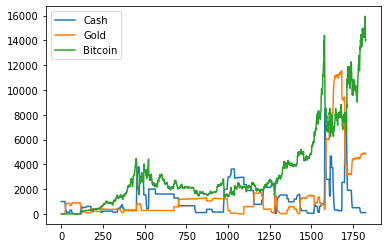

In [209]:
statelist = [[1000,0,0]]
goldchange = 1
bitchange = 1

gold_diff_change = 0
bit_diff_change = 0

gold_transfee = 0.01
bc_transfee = 0.02
num_trades = 0

for i in range(1826):
    cashyest = statelist[-1][0]
    goldyest = statelist[-1][1]
    bityest = statelist[-1][2]
    buy_gold = False
    buy_bc = False

    if i > 0:
        goldchange = 1 + ((df['Gold'][i] - df['Gold'][i-1]) / df['Gold'][i-1])
        bitchange = 1 + ((df['Bitcoin'][i]-df['Bitcoin'][i-1]) / df['Bitcoin'][i-1])
        
        gold_diff_change = gold_diff[i]/df['Gold'][i]
        bit_diff_change = bitcoin_diff[i]/df['Bitcoin'][i]

    #sell gold 
    if(gold_diff_change >= .02):
        cashyest += (goldyest/5) * (1-gold_transfee)
        goldyest = goldyest - (goldyest/5)
        num_trades += 1

    #sell bitcoin   
    if(bit_diff_change >= .2):
        cashyest += (bityest/5) * (1-bc_transfee)
        bityest = bityest - (bityest/5)
        num_trades += 1

    #buy gold
    if(gold_diff_change <= -.02):
        buy_gold = True
        num_trades += 1
      
    #buy bitcoin   
    if(bit_diff_change <= -.2):
        buy_bc = True
        num_trades += 1
        
    if buy_gold and buy_bc:
        goldyest += cashyest/5 * (1-gold_transfee)
        bityest += cashyest/5 * (1 - bc_transfee)
        cashyest = cashyest - 2*(cashyest/5)
    
    elif buy_gold:
        goldyest += cashyest/5 * (1-gold_transfee)
        cashyest = cashyest - (cashyest/5)
    elif buy_bc: 
        bityest += cashyest/5 * (1 - bc_transfee)
        cashyest = cashyest - (cashyest/5)  
    
    if i > 0:
        statelist.append([cashyest, goldyest * goldchange, bityest * bitchange ])
    #if i == 0:
     #   statelist.append([300, 350, 350])
        
        
plt.plot(statelist)
plt.legend(["Cash", "Gold", "Bitcoin"]);
print('Ending Value:', statelist[-1][0] + statelist[-1][1] + statelist[-1][2])
print('Number of Trades:', num_trades)

### Model 5.3
gold - 2%
bitcoin - 20%
sell/buy - 50% 

Ending Value: 18793.7328651392
Number of Trades: 311


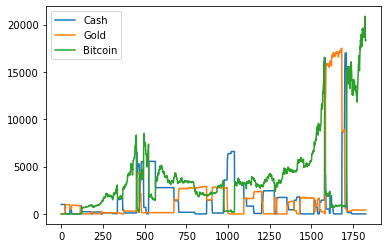

In [204]:
statelist = [[1000,0,0]]
goldchange = 1
bitchange = 1

gold_diff_change = 0
bit_diff_change = 0

gold_transfee = 0.01
bc_transfee = 0.02
num_trades = 0

for i in range(1826):
    cashyest = statelist[-1][0]
    goldyest = statelist[-1][1]
    bityest = statelist[-1][2]
    buy_gold = False
    buy_bc = False

    if i > 0:
        goldchange = 1 + ((df['Gold'][i] - df['Gold'][i-1]) / df['Gold'][i-1])
        bitchange = 1 + ((df['Bitcoin'][i]-df['Bitcoin'][i-1]) / df['Bitcoin'][i-1])
        
        gold_diff_change = gold_diff[i]/df['Gold'][i]
        bit_diff_change = bitcoin_diff[i]/df['Bitcoin'][i]

    #sell gold 
    if(gold_diff_change >= .02):
        cashyest += (goldyest/2) * (1-gold_transfee)
        goldyest = goldyest - (goldyest/2)
        num_trades += 1

    #sell bitcoin   
    if(bit_diff_change >= .2):
        cashyest += (bityest/2) * (1-bc_transfee)
        bityest = bityest - (bityest/2)
        num_trades += 1

    #buy gold
    if(gold_diff_change <= -.02):
        buy_gold = True
        num_trades += 1
      
    #buy bitcoin   
    if(bit_diff_change <= -.2):
        buy_bc = True
        num_trades += 1
        
    if buy_gold and buy_bc:
        goldyest += cashyest/2 * (1-gold_transfee)
        bityest += cashyest/2 * (1 - bc_transfee)
        cashyest = cashyest - 2*(cashyest/2)
    
    elif buy_gold: 
        goldyest += cashyest/2 * (1-gold_transfee)
        cashyest = cashyest - (cashyest/2)
    elif buy_bc: 
        bityest += cashyest/2 * (1 - bc_transfee)
        cashyest = cashyest - (cashyest/2)  
    
    if i > 0:
        statelist.append([cashyest, goldyest * goldchange, bityest * bitchange ])
    #if i == 0:
     #   statelist.append([300, 350, 350])
        
        
plt.plot(statelist)
plt.legend(["Cash", "Gold", "Bitcoin"]);
print('Ending Value:', statelist[-1][0] + statelist[-1][1] + statelist[-1][2])
print('Number of Trades:', num_trades)

### Initial States 

### Model 6.1 
800 cash 100 gold 100 bitcoin

Ending Value: 23498.224644814218
Number of Trades: 311


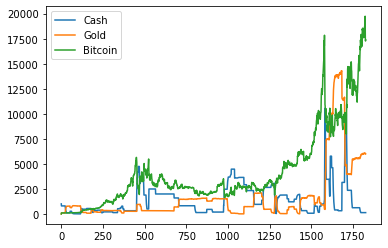

In [205]:
statelist = [[1000,0,0]]
goldchange = 1
bitchange = 1

gold_diff_change = 0
bit_diff_change = 0

gold_transfee = 0.01
bc_transfee = 0.02
num_trades = 0

for i in range(1826):
    cashyest = statelist[-1][0]
    goldyest = statelist[-1][1]
    bityest = statelist[-1][2]
    buy_gold = False
    buy_bc = False

    if i > 0:
        goldchange = 1 + ((df['Gold'][i] - df['Gold'][i-1]) / df['Gold'][i-1])
        bitchange = 1 + ((df['Bitcoin'][i]-df['Bitcoin'][i-1]) / df['Bitcoin'][i-1])
        
        gold_diff_change = gold_diff[i]/df['Gold'][i]
        bit_diff_change = bitcoin_diff[i]/df['Bitcoin'][i]

    #sell gold 
    if(gold_diff_change >= .02):
        cashyest += (goldyest/5) * (1-gold_transfee)
        goldyest = goldyest - (goldyest/5)
        num_trades += 1

    #sell bitcoin   
    if(bit_diff_change >= .2):
        cashyest += (bityest/5) * (1-bc_transfee)
        bityest = bityest - (bityest/5)
        num_trades += 1

    #buy gold
    if(gold_diff_change <= -.02):
        buy_gold = True
        num_trades += 1
      
    #buy bitcoin   
    if(bit_diff_change <= -.2):
        buy_bc = True
        num_trades += 1
        
    if buy_gold and buy_bc:
        goldyest += cashyest/5 * (1-gold_transfee)
        bityest += cashyest/5 * (1 - bc_transfee)
        cashyest = cashyest - 2*(cashyest/5)
    
    elif buy_gold:
        goldyest += cashyest/5 * (1-gold_transfee)
        cashyest = cashyest - (cashyest/5)
    elif buy_bc: 
        bityest += cashyest/5 * (1 - bc_transfee)
        cashyest = cashyest - (cashyest/5)  
    
    if i > 0:
        statelist.append([cashyest, goldyest * goldchange, bityest * bitchange ])
    if i == 0:
        statelist.append([800, 100, 100])
        
        
plt.plot(statelist)
plt.legend(["Cash", "Gold", "Bitcoin"]);
print('Ending Value:', statelist[-1][0] + statelist[-1][1] + statelist[-1][2])
print('Number of Trades:', num_trades)

### Model 6.2
100 cash 450 gold 450 bitcoin

Ending Value: 39283.116903477414
Number of Trades: 311


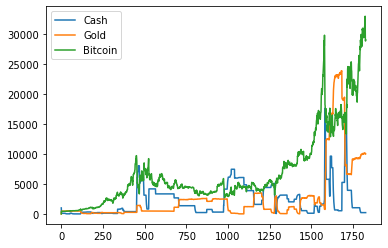

In [207]:
statelist = [[1000,0,0]]
goldchange = 1
bitchange = 1

gold_diff_change = 0
bit_diff_change = 0

gold_transfee = 0.01
bc_transfee = 0.02
num_trades = 0

for i in range(1826):
    cashyest = statelist[-1][0]
    goldyest = statelist[-1][1]
    bityest = statelist[-1][2]
    buy_gold = False
    buy_bc = False

    if i > 0:
        goldchange = 1 + ((df['Gold'][i] - df['Gold'][i-1]) / df['Gold'][i-1])
        bitchange = 1 + ((df['Bitcoin'][i]-df['Bitcoin'][i-1]) / df['Bitcoin'][i-1])
        
        gold_diff_change = gold_diff[i]/df['Gold'][i]
        bit_diff_change = bitcoin_diff[i]/df['Bitcoin'][i]

    #sell gold 
    if(gold_diff_change >= .02):
        cashyest += (goldyest/5) * (1-gold_transfee)
        goldyest = goldyest - (goldyest/5)
        num_trades += 1

    #sell bitcoin   
    if(bit_diff_change >= .2):
        cashyest += (bityest/5) * (1-bc_transfee)
        bityest = bityest - (bityest/5)
        num_trades += 1

    #buy gold
    if(gold_diff_change <= -.02):
        buy_gold = True
        num_trades += 1
      
    #buy bitcoin   
    if(bit_diff_change <= -.2):
        buy_bc = True
        num_trades += 1
        
    if buy_gold and buy_bc:
        goldyest += cashyest/5 * (1-gold_transfee)
        bityest += cashyest/5 * (1 - bc_transfee)
        cashyest = cashyest - 2*(cashyest/5)
    
    elif buy_gold:
        goldyest += cashyest/5 * (1-gold_transfee)
        cashyest = cashyest - (cashyest/5)
    elif buy_bc: 
        bityest += cashyest/5 * (1 - bc_transfee)
        cashyest = cashyest - (cashyest/5)  
    
    if i > 0:
        statelist.append([cashyest, goldyest * goldchange, bityest * bitchange ])
    if i == 0:
        statelist.append([100, 450, 450])
        
        
plt.plot(statelist)
plt.legend(["Cash", "Gold", "Bitcoin"]);
print('Ending Value:', statelist[-1][0] + statelist[-1][1] + statelist[-1][2])
print('Number of Trades:', num_trades)

### Model 6.3 
0 cash, 500 gold, 500 bitcoin

Ending Value: 41538.101511857996
Number of Trades: 311


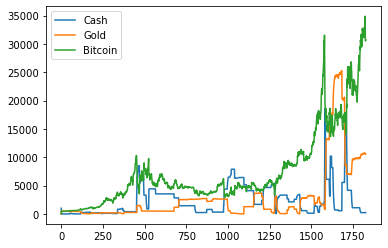

In [222]:
statelist = [[1000,0,0]]
goldchange = 1
bitchange = 1

gold_diff_change = 0
bit_diff_change = 0

gold_transfee = 0.01
bc_transfee = 0.02
num_trades = 0

for i in range(1826):
    cashyest = statelist[-1][0]
    goldyest = statelist[-1][1]
    bityest = statelist[-1][2]
    buy_gold = False
    buy_bc = False

    if i > 0:
        goldchange = 1 + ((df['Gold'][i] - df['Gold'][i-1]) / df['Gold'][i-1])
        bitchange = 1 + ((df['Bitcoin'][i]-df['Bitcoin'][i-1]) / df['Bitcoin'][i-1])
        
        gold_diff_change = gold_diff[i]/df['Gold'][i]
        bit_diff_change = bitcoin_diff[i]/df['Bitcoin'][i]

    #sell gold 
    if(gold_diff_change >= .02):
        cashyest += (goldyest/5) * (1-gold_transfee)
        goldyest = goldyest - (goldyest/5)
        num_trades += 1

    #sell bitcoin   
    if(bit_diff_change >= .2):
        cashyest += (bityest/5) * (1-bc_transfee)
        bityest = bityest - (bityest/5)
        num_trades += 1

    #buy gold
    if(gold_diff_change <= -.02):
        buy_gold = True
        num_trades += 1
      
    #buy bitcoin   
    if(bit_diff_change <= -.2):
        buy_bc = True
        num_trades += 1
        
    if buy_gold and buy_bc:
        goldyest += cashyest/5 * (1-gold_transfee)
        bityest += cashyest/5 * (1 - bc_transfee)
        cashyest = cashyest - 2*(cashyest/5)
    
    elif buy_gold:
        goldyest += cashyest/5 * (1-gold_transfee)
        cashyest = cashyest - (cashyest/5)
    elif buy_bc: 
        bityest += cashyest/5 * (1 - bc_transfee)
        cashyest = cashyest - (cashyest/5)  
    
    if i > 0:
        statelist.append([cashyest, goldyest * goldchange, bityest * bitchange ])
    if i == 0:
        statelist.append([0, 500,500])
        
        
plt.plot(statelist)
plt.legend(["Cash", "Gold", "Bitcoin"]);
print('Ending Value:', statelist[-1][0] + statelist[-1][1] + statelist[-1][2])
print('Number of Trades:', num_trades)

Text(0.5, 1.0, 'Asset Breakdown of the last 100 Days')

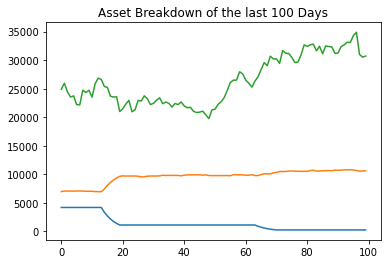

In [223]:
plt.plot(statelist[-100:])
plt.title("Asset Breakdown of the last 100 Days")